In [1]:
import numpy as np
import sys
import gsw
import xarray as xr
import numpy as np
from scipy import integrate
from copy import deepcopy 
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from xgcm import Grid 
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v4'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

In [3]:
## Load 2D Monthly data...SSH 
data_dir= ECCO_dir + '/nctiles_monthly'
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['SALT','SSHDYN','OBPNOPAB'],\
                                           years_to_load=range(2011,2017)).load() # if desired, add after 'SSH','NEW_VAR',... 'SSH','OBP',                                           
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

loading files of  OBPNOPAB
loading files of  SALT
loading files of  SSHDYN


In [4]:
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)

In [6]:
# load steric height and steric pressure already computed 
ds_den0 = '/Users/jakesteinberg/Documents/NASA_OSTST/rho_steric_2011_2017.nc'
ds_den = xr.open_dataset(ds_den0)

In [8]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
# XC distance from grid center point to center point 
# XG distance from grid egde (where u is defined) to grid edge (finite difference of values at XC will be placed here)
grid = Grid(ecco_monthly_ds, metrics=metrics)

In [337]:
tile_num=10
# pull out lats and lons
lons = ecco_monthly_ds.XC.sel(tile=tile_num)
lats = ecco_monthly_ds.YC.sel(tile=tile_num)
lons_g = ecco_monthly_ds.XG.sel(tile=tile_num)
lats_g = ecco_monthly_ds.YG.sel(tile=tile_num)

In [311]:
dep = ecco_monthly_ds.Depth
testx = grid.diff(dep,axis='X')/(ecco_monthly_ds.dxG.data/1000)
testy = grid.diff(dep,axis='Y')/(ecco_monthly_ds.dyG.data/1000)
H_x = grid.interp(testx,'X')
H_y = grid.interp(testy,'Y')
gradH_np = np.sqrt(H_x.isel(tile=tile_num).data**2 + H_y.isel(tile=tile_num).data**2)
gradH = xr.DataArray(
    data=gradH_np,
    dims=["j", "i"],
    coords=dict(
        i=(["i"], np.arange(90)), j=(["j"], np.arange(90)),
    ),
)

In [462]:
g = 9.81 
rho0 = 1035

s_press = rho0*g*(ecco_monthly_ds.SSHDYN-ecco_monthly_ds.SSHDYN.mean(dim='time'))
s_press = s_press.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
obp = rho0*g*(ecco_monthly_ds.OBPNOPAB-ecco_monthly_ds.OBPNOPAB.mean(dim='time'))
obp = obp.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
ster = 1*(ds_den.steric_p-ds_den.steric_p.mean(dim='time'))
ster = ster.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

basex_eta = grid.diff(s_press,axis='X')/(ecco_monthly_ds.dxG.data/1000)
basey_eta = grid.diff(s_press,axis='Y')/(ecco_monthly_ds.dyG.data/1000)
deta_dx = grid.interp(basex_eta,'X')
deta_dy = grid.interp(basey_eta,'Y')
basex = grid.diff(obp,axis='X')/(ecco_monthly_ds.dxG.data/1000)
basey = grid.diff(obp,axis='Y')/(ecco_monthly_ds.dyG.data/1000)
dobp_dx = grid.interp(basex,'X')
dobp_dy = grid.interp(basey,'Y')
basex = grid.diff(ster,axis='X')/(ecco_monthly_ds.dxG.data/1000)
basey = grid.diff(ster,axis='Y')/(ecco_monthly_ds.dyG.data/1000)
dster_dx = grid.interp(basex,'X')
dster_dy = grid.interp(basey,'Y')
rho_bot = ds_den.rho.isel(tile=tile_num)
topox = (rho_bot.max(dim=['layer']) - rho_bot.max(dim=['layer']).mean(dim='time'))*g*H_x.isel(tile=tile_num) 
topoy = (rho_bot.max(dim=['layer']) - rho_bot.max(dim=['layer']).mean(dim='time'))*g*H_y.isel(tile=tile_num)

In [420]:
np.nanmax(ster)

3241.111988451332

In [384]:
ocx = ecco_monthly_ds.XC.isel(tile=tile_num).copy()
ocy = ecco_monthly_ds.YC.isel(tile=tile_num).copy()
ocx = ocx.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
ocy = ocy.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

[[0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
[[-89.5 -88.5 -87.5 -86.5 -85.5 -84.5]
 [-89.5 -88.5 -87.5 -86.5 -85.5 -84.5]
 [-89.5 -88.5 -87.5 -86.5 -85.5 -84.5]
 [-89.5 -88.5 -87.5 -86.5 -85.5 -84.5]
 [-89.5 -88.5 -87.5 -86.5 -85.5 -84.5]
 [-89.5 -88.5 -87.5 -86.5 -85.5 -84.5]]
[[30.976704 30.976704 30.976704 30.976704 30.976704 30.976704]
 [30.112358 30.112358 30.112358 30.112358 30.112358 30.112358]
 [29.240158 29.240158 29.240158 29.240158 29.240158 29.240158]
 [28.360258 28.360258 28.360258 28.360258 28.360258 28.360258]
 [27.472822 27.472822 27.472822 27.472822 27.472822 27.472822]
 [26.578028 26.578028 26.578028 26.578028 26.578028 26.578028]]
[[       nan        nan        nan        nan        nan        nan]
 [       nan -1838.2041 -1734.9519 -1751.8962        nan        nan]
 [-1759.7933 -1653.5277 -1598.6847 -1612.7289 -1683.5916 -1752.4258]
 [-1581.7955 -1506.962  -1486.0105 -1502.3015 -1554.

(25.828027725219727, 31.726703643798828)

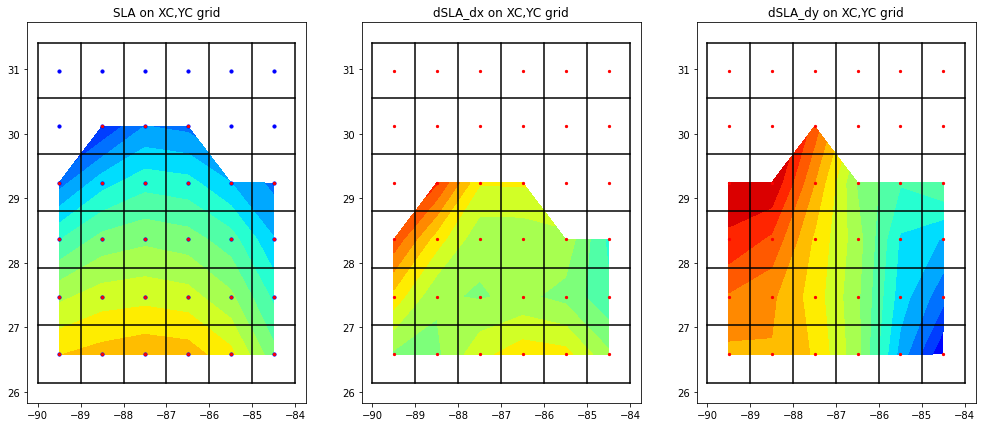

In [386]:
lon_w = -92
lon_e = -84
lat_s = 26
lat_n = 31
tglon = np.where((lons[:,0] > lon_w) & (lons[:,0] < lon_e))[0]
tglat = np.where((lats[0,:] > lat_s) & (lats[0,:] < lat_n))[0]
tglon_g = np.where((lons_g[:,0] >= (lon_w-.5)) & (lons_g[:,0] <= (lon_e+0.5)))[0]
tglat_g = np.where((lats_g[0,:] >= (lat_s-.5)) & (lats_g[0,:] <= (lat_n+0.5)))[0]
print(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0)[tglon,tglat].data.T)
print(lons[tglon,tglat].data.T)
print(lats[tglon,tglat].data.T)
print(s_press.isel(tile=tile_num)[1,tglon,tglat].data.T)
print(deta_dx.isel(tile=tile_num)[1,tglon,tglat].data.T)
print(deta_dy.isel(tile=tile_num)[1,tglon,tglat].data.T)

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(17,7))
# Kc = ax1.pcolor(lons[tglon,tglat], lats[tglon,tglat], s_press.isel(tile=tile_num)[1,tglon,tglat], cmap='jet', vmin=-2000, vmax=-1000)
Kc = ax1.contourf(lons[tglon,tglat], lats[tglon,tglat], s_press.isel(tile=tile_num)[1,tglon,tglat], np.linspace(-2000,-1000, 20,endpoint=True), cmap='jet', vmin=-2000, vmax=-1000)
ax1.scatter(lons[tglon,tglat], lats[tglon,tglat], s=10, color='b')
ax1.scatter(ocx, ocy, s=5, color='r')
ax1.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g], ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g],'k-')
ax1.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g].T, ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g].T,'k-')
ax1.set_title('SLA on XC,YC grid')
ax1.set_xlim([np.nanmin(lons[tglon,tglat])-.75, np.nanmax(lons[tglon,tglat])+.75])
ax1.set_ylim([np.nanmin(lats[tglon,tglat])-.75, np.nanmax(lats[tglon,tglat])+.75])
Kc = ax2.contourf(lons[tglon,tglat], lats[tglon,tglat], deta_dx.isel(tile=tile_num)[1,tglon,tglat], np.linspace(0,2, 20,endpoint=True), cmap='jet', vmin=0, vmax=2)
ax2.scatter(lons[tglon,tglat], lats[tglon,tglat], s=5, color='r')
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g], ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g],'k-')
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g].T, ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g].T,'k-')
ax2.set_title('dSLA_dx on XC,YC grid')
ax2.set_xlim([np.nanmin(lons[tglon,tglat])-.75, np.nanmax(lons[tglon,tglat])+.75])
ax2.set_ylim([np.nanmin(lats[tglon,tglat])-.75, np.nanmax(lats[tglon,tglat])+.75])
Kc = ax3.contourf(lons[tglon,tglat], lats[tglon,tglat], deta_dy.isel(tile=tile_num)[1,tglon,tglat], np.linspace(-2,1, 20,endpoint=True), cmap='jet', vmin=-2, vmax=1)
ax3.scatter(lons[tglon,tglat], lats[tglon,tglat], s=5, color='r')
ax3.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g], ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g],'k-')
ax3.plot(ecco_monthly_ds.XG.isel(tile=tile_num)[tglon_g,tglat_g].T, ecco_monthly_ds.YG.isel(tile=tile_num)[tglon_g,tglat_g].T,'k-')
ax3.set_title('dSLA_dy on XC,YC grid')
ax3.set_xlim([np.nanmin(lons[tglon,tglat])-.75, np.nanmax(lons[tglon,tglat])+.75])
ax3.set_ylim([np.nanmin(lats[tglon,tglat])-.75, np.nanmax(lats[tglon,tglat])+.75])

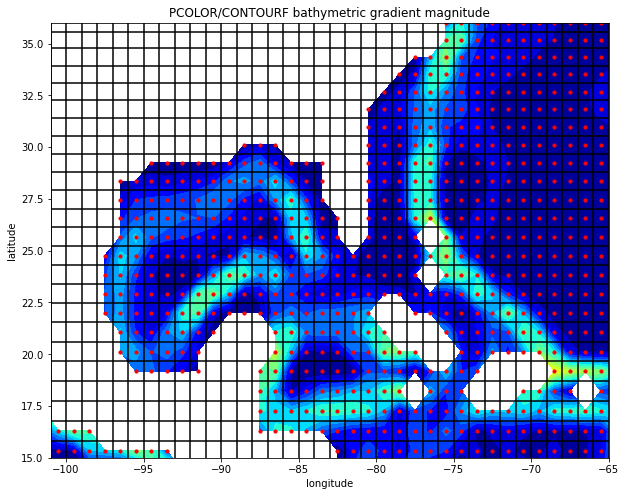

In [371]:
tile_to_plot = gradH
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) != 0, np.nan)
f, ax = plt.subplots(1,1,figsize=(10,8))
# use pcolor with 'lons' and 'lats' for the plot x and y axes 
# ax.pcolor(lons, lats, tile_to_plot, vmin=0, vmax=50, cmap='jet')
ax.contourf(lons, lats, tile_to_plot, np.linspace(0,50, 20,endpoint=True), cmap='jet', vmin=0, vmax=50)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-')
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-')
# ax.scatter(ecco_monthly_ds.XC.isel(tile=tile_num), ecco_monthly_ds.YC.isel(tile=tile_num), color='r', s=1)
ax.scatter(ocx, ocy, s=10, color='r')
ax.set_title('PCOLOR/CONTOURF bathymetric gradient magnitude')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_xlim([-101, -65]); ax.set_ylim([15, 36]);

In [464]:
deta_dx2 = (deta_dx.isel(tile=tile_num)).var(dim='time')
deta_dy2 = (deta_dy.isel(tile=tile_num)).var(dim='time')
K_eta = np.sqrt(0.5*(deta_dx2 + deta_dy2))
dster_dx2 = (dster_dx.isel(tile=tile_num)).var(dim='time')
dster_dy2 = (dster_dy.isel(tile=tile_num)).var(dim='time')
K_ster = np.sqrt(0.5*(dster_dx2 + dster_dy2))
dobp_dx2 = (dobp_dx.isel(tile=tile_num)).var(dim='time')
dobp_dy2 = (dobp_dy.isel(tile=tile_num)).var(dim='time')
K_obp = np.sqrt(0.5*(dobp_dx2 + dobp_dy2))

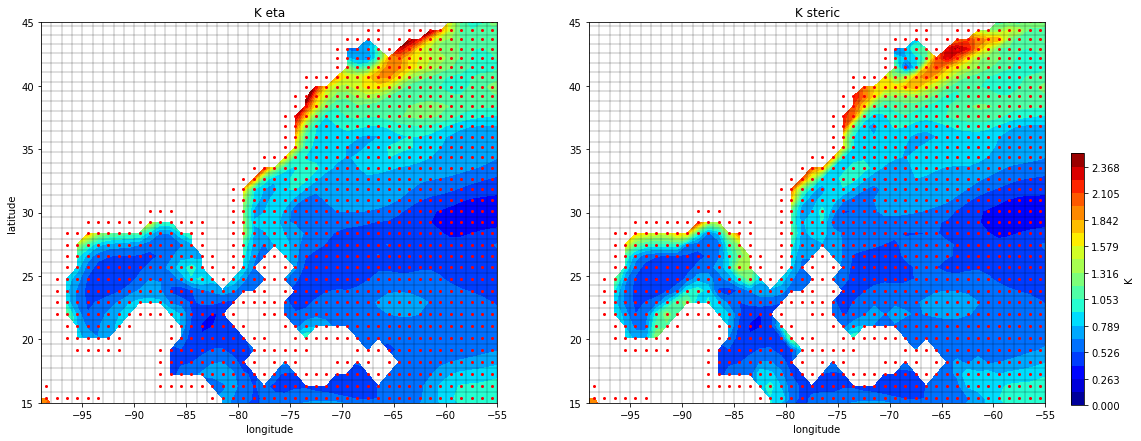

In [424]:
lon_range = [-99, -55]
lat_range = [15, 45]

f, (ax1,ax2) = plt.subplots(1,2,figsize=(18,7))
maxlim = 2.5
tile_to_plot = K_eta
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
Kc = ax1.contourf(lons, lats, tile_to_plot, np.linspace(0, maxlim, 20,endpoint=True), cmap='jet', vmin=0, vmax=maxlim)
# Kc = ax1.pcolor(lons, lats, tile_to_plot, cmap='jet', vmin=0, vmax=maxlim)
ax1.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.25)
ax1.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.25)
ax1.scatter(ocx, ocy, s=4, color='r')
ax1.set_title('K eta')
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
ax1.set_xlim(lon_range); ax1.set_ylim(lat_range);

tile_to_plot = K_ster
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
Kc = ax2.contourf(lons, lats, tile_to_plot, np.linspace(0, maxlim, 20,endpoint=True), cmap='jet', vmin=0, vmax=maxlim)
# Kc = ax2.pcolor(lons, lats, tile_to_plot, cmap='jet', vmin=0, vmax=maxlim)
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.25)
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.25)
ax2.scatter(ocx, ocy, s=4, color='r')
ax2.set_title('K steric')
ax2.set_xlabel('longitude')
ax2.set_xlim(lon_range); ax2.set_ylim(lat_range);

cbpos = [0.92, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='K')

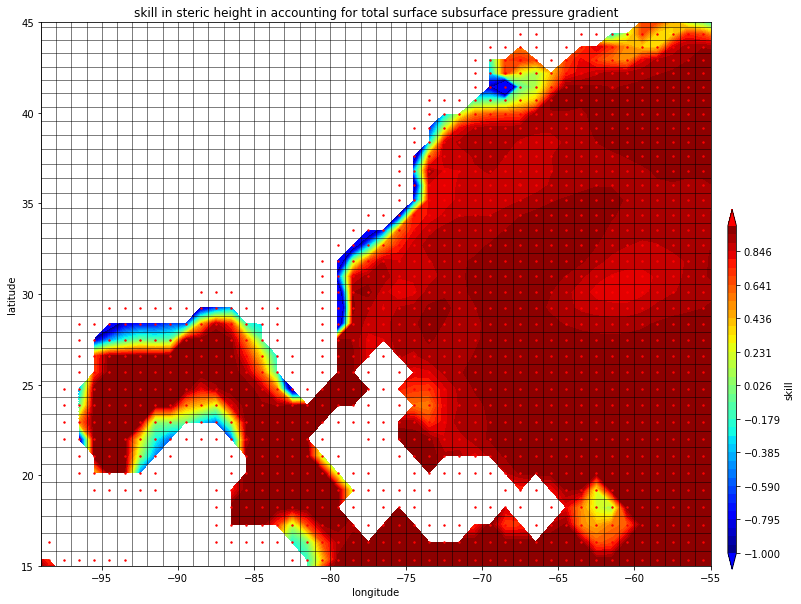

In [425]:
skill = 1 - (((dster_dx.isel(tile=tile_num) - deta_dx.isel(tile=tile_num)).var(dim='time') + \
             (dster_dy.isel(tile=tile_num) - deta_dy.isel(tile=tile_num)).var(dim='time')) / ((dster_dx.isel(tile=tile_num)).var(dim='time') + (dster_dy.isel(tile=tile_num)).var(dim='time')))
f, ax = plt.subplots(1,1,figsize=(12,10))
tile_to_plot = skill
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('jet')
colMap.set_under(color='b')
Kc = ax.contourf(lons, lats, tile_to_plot, np.linspace(-1, 1, 40,endpoint=True), cmap=colMap, vmin=-1, vmax=1, extend='both')
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax.scatter(ocx, ocy, s=2, color='r')
ax.set_title('skill in steric height in accounting for total surface subsurface pressure gradient')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_xlim(lon_range); ax.set_ylim(lat_range);
cbpos = [0.92, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='skill')

In [393]:
K_eta_minus_ster = np.sqrt(0.5*((deta_dx.isel(tile=tile_num)-dster_dx.isel(tile=tile_num)).var(dim='time') + \
                                (deta_dy.isel(tile=tile_num)-dster_dy.isel(tile=tile_num)).var(dim='time')))
K_eta_minus_ster_minus_topo = np.sqrt(0.5*((deta_dx.isel(tile=tile_num) - dster_dx.isel(tile=tile_num) - topox).var(dim='time') + \
                                (deta_dy.isel(tile=tile_num) - dster_dy.isel(tile=tile_num) - topoy).var(dim='time')))

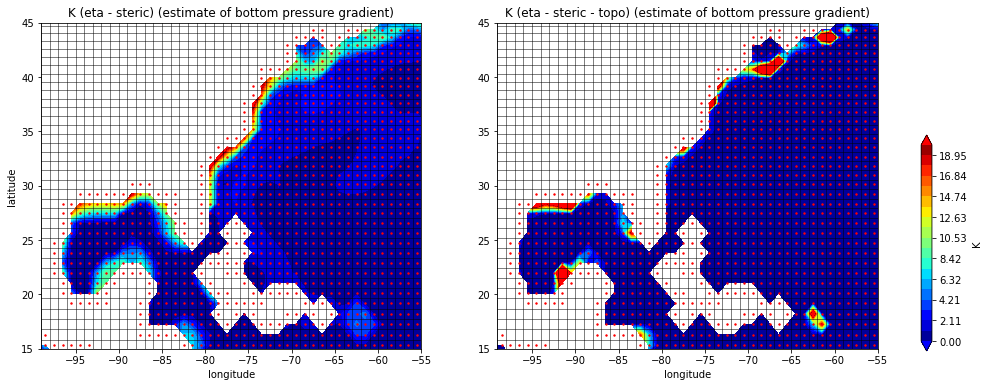

In [473]:
# approxCx = (rho_bot.max(dim=['layer']))*g*H_x.isel(tile=tile_num) # dster_dx.isel(tile=tile_num) + 
# approxCy = (rho_bot.max(dim=['layer']))*g*H_y.isel(tile=tile_num) # dster_dy.isel(tile=tile_num) + 
# skill = 1 - (((approxCx - dobp_dx.isel(tile=tile_num)).var(dim='time') + \
#              (approxCy - dobp_dy.isel(tile=tile_num)).var(dim='time')) / (approxCx.var(dim='time') + approxCy.var(dim='time')))
f, (ax,ax2) = plt.subplots(1,2,figsize=(15,6))
maxlim = 3
tile_to_plot = K_eta_minus_ster
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('jet'); colMap.set_under(color='b'); colMap.set_over(color='r');
Kc = ax.contourf(lons, lats, tile_to_plot, np.linspace(0,maxlim,20), cmap=colMap, vmin=0, vmax=maxlim, extend='both')
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax.scatter(ocx, ocy, s=2, color='r')
ax.set_title('K (eta - steric) (estimate of bottom pressure gradient)')
ax.set_xlabel('longitude'); ax.set_ylabel('latitude');
ax.set_xlim(lon_range); ax.set_ylim(lat_range);

maxlim = 20; minlim=0;
tile_to_plot = K_eta_minus_ster_minus_topo; 
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('jet'); colMap.set_under(color='b');
Kc = ax2.contourf(lons, lats, tile_to_plot, np.linspace(minlim,maxlim,20), cmap=colMap, vmin=minlim, vmax=maxlim, extend='both')
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax2.scatter(ocx, ocy, s=2, color='r')
ax2.set_title('K (eta - steric - topo) (estimate of bottom pressure gradient)')
ax2.set_xlabel('longitude'); ax.set_ylabel('latitude');
ax2.set_xlim(lon_range); ax2.set_ylim(lat_range);
cbpos = [0.94, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='K')

In [486]:
np.shape((deta_dx.isel(tile=tile_num)-dster_dx.isel(tile=tile_num)))
np.shape(topox)

(72, 90, 90)

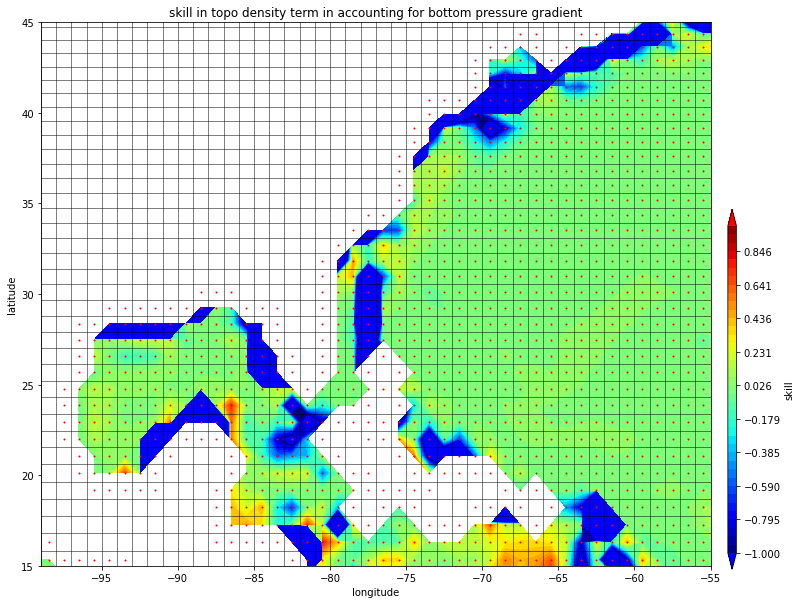

In [484]:
# skill = 1 - (((topox - (deta_dx.isel(tile=tile_num)-dster_dx.isel(tile=tile_num))).var(dim='time') + \
#              (topoy - (deta_dy.isel(tile=tile_num)-dster_dy.isel(tile=tile_num))).var(dim='time')) / ((topox).var(dim='time') + (topoy).var(dim='time')))

skill = 1 - ((((deta_dx.isel(tile=tile_num)-dster_dx.isel(tile=tile_num)) - topox).var(dim='time') + \
             ((deta_dy.isel(tile=tile_num)-dster_dy.isel(tile=tile_num))-topoy).var(dim='time')) / ((deta_dx.isel(tile=tile_num)-dster_dx.isel(tile=tile_num)).var(dim='time') + (deta_dy.isel(tile=tile_num)-dster_dy.isel(tile=tile_num)).var(dim='time')))

f, ax = plt.subplots(1,1,figsize=(12,10))
tile_to_plot = skill
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('jet')
colMap.set_under(color='b');colMap.set_over(color='r')
Kc = ax.contourf(lons, lats, tile_to_plot, np.linspace(-1, 1, 40,endpoint=True), cmap=colMap, vmin=-1, vmax=1, extend='both')
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax.set_title('skill in topo density term in accounting for bottom pressure gradient')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.scatter(ocx, ocy, s=1, color='r')
ax.set_xlim(lon_range); ax.set_ylim(lat_range);
cbpos = [0.92, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='skill')

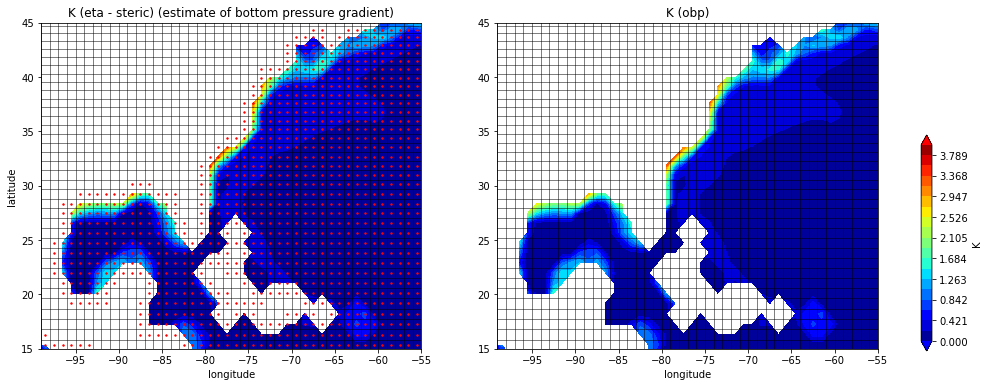

In [465]:
f, (ax,ax2) = plt.subplots(1,2,figsize=(15,6))
maxlim = 4
tile_to_plot = K_eta_minus_ster
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('jet'); colMap.set_under(color='b'); colMap.set_over(color='r');
Kc = ax.contourf(lons, lats, tile_to_plot, np.linspace(0,maxlim,20), cmap=colMap, vmin=0, vmax=maxlim, extend='both')
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax.scatter(ocx, ocy, s=2, color='r')
ax.set_title('K (eta - steric) (estimate of bottom pressure gradient)')
ax.set_xlabel('longitude'); ax.set_ylabel('latitude');
ax.set_xlim(lon_range); ax.set_ylim(lat_range);

tile_to_plot = K_obp; 
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
colMap = plt.get_cmap('jet'); colMap.set_under(color='b');
Kc = ax2.contourf(lons, lats, tile_to_plot, np.linspace(0,maxlim,20), cmap=colMap, vmin=0, vmax=maxlim, extend='both')
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax2.set_title('K (obp)')
ax2.set_xlabel('longitude'); ax.set_ylabel('latitude');
ax2.set_xlim(lon_range); ax2.set_ylim(lat_range);
cbpos = [0.94, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='K')

In [438]:
print(np.where((lons[:,0] > -95) & (lons[:,0] < -93))[0])
print(np.where((lats[0,:] > 25) & (lats[0,:] < 30))[0])
lon_test = 36
lat_test = 70 # 69 
print(lons[lon_test,lat_test].data)
print(lats[lon_test, lat_test].data)

[35 36]
[69 70 71 72 73]
-91.5
28.360258


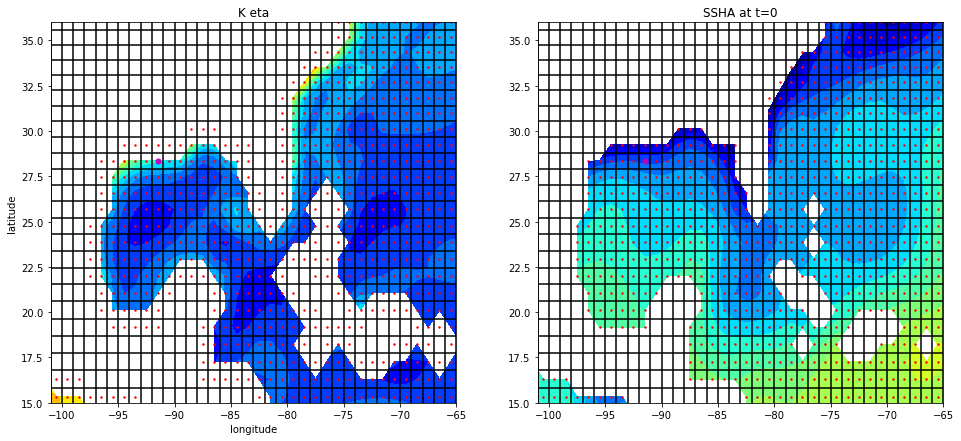

In [439]:
tile_to_plot = K_eta; maxlim = 3
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

tile_to_plot2 = rho0*g*(ecco_monthly_ds.SSHDYN-ecco_monthly_ds.SSHDYN.mean(dim='time')).isel(tile=tile_num)[0]; 
tile_to_plot2= tile_to_plot2.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

f, (ax,ax2) = plt.subplots(1,2,figsize=(16,7))
ax.contourf(lons, lats, tile_to_plot, np.linspace(0,maxlim,20,endpoint=True), cmap='jet', vmin=0, vmax=maxlim)
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-')
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-')
ax.scatter(ocx, ocy, s=2, color='r')
ax.scatter(lons[lon_test,lat_test], lats[lon_test, lat_test], color='m', s=25)
ax.set_title('K eta'); ax.set_xlabel('longitude'); ax.set_ylabel('latitude');
ax.set_xlim([-101, -65]); ax.set_ylim([15, 36]);

ax2.contourf(lons, lats, tile_to_plot2, np.linspace(-2000,1000,20,endpoint=True), cmap='jet', vmin=-2000, vmax=1000)
# ax2.pcolormesh(lons, lats, tile_to_plot2, cmap='jet', vmin=-2000, vmax=maxlim)
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-')
ax2.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-')
ax2.scatter(ocx, ocy, s=2, color='r')
ax2.scatter(lons[lon_test,lat_test], lats[lon_test, lat_test], color='m', s=25)
ax2.set_title('SSHA at t=0'); ax.set_xlabel('longitude'); ax.set_ylabel('latitude');
ax2.set_xlim([-101, -65]); ax2.set_ylim([15, 36]);

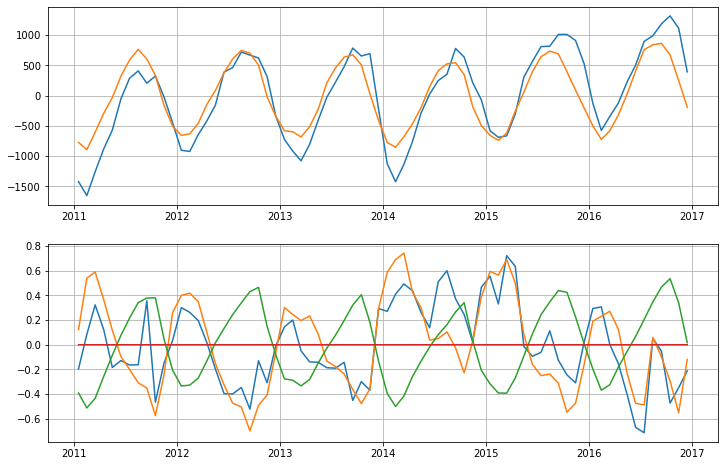

In [454]:
f, (ax,ax2) = plt.subplots(2,1,figsize=(12,8))
# ax.plot(ecco_monthly_ds.time,deta_dx.isel(tile=tile_num)[:, 36, lat_test])
# ax.plot(ecco_monthly_ds.time,dster_dx.isel(tile=tile_num)[:, 36, lat_test])
# ax.plot(ecco_monthly_ds.time,topox[:, 36, lat_test])
# ax.plot(ecco_monthly_ds.time,deta_dy.isel(tile=tile_num)[:, 36, 69])
# ax.plot(ecco_monthly_ds.time,deta_dx.isel(tile=tile_num)[:, 36, 74])
# ax.plot(ecco_monthly_ds.time,deta_dy.isel(tile=tile_num)[:, 36, 74])
ax.grid()

ax.plot(ecco_monthly_ds.time,rho0*g*(ecco_monthly_ds.SSHDYN-ecco_monthly_ds.SSHDYN.mean(dim='time')).isel(tile=tile_num)[:, lon_test, lat_test])
ax.plot(ecco_monthly_ds.time,ster.isel(tile=tile_num)[:, lon_test, lat_test])
# ax.plot(ecco_monthly_ds.time,10000*(ds_den.steric-ds_den.steric.mean(dim='time')).isel(tile=tile_num)[:, lon_test, lat_test])

ax2.plot(ecco_monthly_ds.time,deta_dy.isel(tile=tile_num)[:, lon_test, lat_test])
ax2.plot(ecco_monthly_ds.time,dster_dy.isel(tile=tile_num)[:, lon_test, lat_test])
ax2.plot(ecco_monthly_ds.time,topoy[:, lon_test, lat_test])
ax2.plot(ecco_monthly_ds.time,dobp_dy.isel(tile=tile_num)[:, lon_test, lat_test])
ax2.grid()
# ax2.plot(ecco_monthly_ds.time,dster_dy.isel(tile=tile_num)[:, 36, 74])
# ax2.plot(ecco_monthly_ds.time,dobp_dx.isel(tile=tile_num)[:, 36, 74])
# ax2.plot(ecco_monthly_ds.time,topox[:, 36, 74])

In [ ]:
f, ax1 = plt.subplots(1,1,figsize=(8,6))
maxlim = 0.0004
tile_to_plot = K_obp
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
Kc = ax1.contourf(lons, lats, tile_to_plot, np.linspace(0, maxlim, 20,endpoint=True), cmap='jet', vmin=0, vmax=maxlim)
ax1.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.5)
ax1.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.5)
ax1.set_title('K eta')
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
ax1.set_xlim([-99, -70]); ax1.set_ylim([17, 36]);
cbpos = [0.94, 0.12, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='K')